# Price prediction of short-term rentals of accommodation facilities on Airbnb using XGBoost model

In [79]:
##importing libraries and setting display options

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from vincenty import vincenty
from textblob import TextBlob
import nltk
from langdetect import DetectorFactory, detect, detect_langs
from scipy. stats import skew
from statistics import mode
import seaborn as sn

import time
from sklearn.model_selection import train_test_split, cross_val_score 
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.inspection import partial_dependence, plot_partial_dependence

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Table of Contents
[Executive summary](#Executive_summary)
    
[1. The dataset](#The_dataset)

[2. Creating new variables](#Creating_new_variables)

[3. Missing values analysis](#Missing_values_analysis)

[4. Dataset restriction](#Dataset_restriction)

[5. Cleaning and transformations of variables](#Cleaning_and_transformations_of_variables)

&emsp; [5.1. Target variable](#Target_variable)

&emsp; [5.2. Transformations of continous variables](#Transformations_of_continous_variables)

&emsp; [5.3. Transformations of other variables](#Transformations_of_other_variables)

[6. Building XGBoost models](#Building_XGBoost_models)

&emsp; [6.1. Dataset split and hyperparameters tuning](#Dataset_split_and_hyperparameters_tuning)

&emsp; [6.2. Comparing results of different models](#Comparing_results_of_different_models)

&emsp; [6.3. Selecting final model](#Selecting_final_model)

&emsp; [6.4. Model evaluation](#Model_evaluation)

&emsp;&emsp; [6.4.1. Feature importance](#Feature_importance)

&emsp;&emsp; [6.4.2. Partial dependence plots](#Partial_dependence_plots)

[Conclusions](#Conclusions)

# Executive summary <a class="anchor" id="Executive_summary"></a>

Setting the right price for an Airbnb rental property is important, especially in large cities like Barcelona, where exists strong competition. Setting a price that is too high can cause rental difficulties. On the other hand, a price that is too low will result in a loss of the potential income that could be earned from renting the property.

Currently, Airbnb platform offers some support in this regard by showing the average price of rentals in the nearest area, taking into account the number of available beds in a given accommodation facility. However, it ignores many other factors that can have a significant impact on determining an appropriate price, such as: available amenities, number of bathrooms, type of accommodation, distance from the city center or score of ratings given by guests. The aim of this project was building XGBoost model to make predictions on rental prices of accommodation facilities in Barcelona listed on Airbnb portal. With the use of such model, it could be created a tool to assist hosts in determining an appropriate rental price, as well as showing how the price could change after making certain changes, such as adding or removing a particular amenity to/from the property. On the other hand, it could also be useful for those tourists interested in renting to determine whether a particular accommodation is worth its price. Model concentrated on tourist-oriented accommodation facilities, i.e. those that were available for short-term rental (less than 30 days).

In the first part of the report dataset used in the project was described. Later, data cleaning and transformations were performed, and some new variables were added. Next, hyperparameters tuning for XGBoost model was performed in order to choose final model which was later evaluated based on error metric. Also, relative feature importance was calculated and partial dependence plots for continous variables were created.


# 1. The dataset <a class="anchor" id="The_dataset"></a>

The dataset used in this project comes from insideairbnb.com and contains characteristics of accommodation facilities and its hosts present on Airbnb site in 2021 in Barcelona. Dataset used for further cleaning and processing had 67788 observations and 24 variables.

#### Description of variables:

- price - price in Euro for one night (target variable)
- host_is_superhost - determines whether the host of a particular property holds a special badge awarded only to the most experienced and valued of them
- host_identity_verified - determines whether identity of host was verified
- accommodates - maximum number of people the property accommodates
- latitude - latitude of accommodation facility
- longitude - longitude of accommodation facility
- bathrooms_text - number of bathrooms
- minimum_nights - minimum lenght of stay in nights
- maximum_nights - maximum length of stay in nights
- availability_30 - number of nights property is available to be rented in the upcoming 30 days
- availability_90 - number of nights property is available to be rented in the upcoming 90 days
- number_of_reviews - number of reviews given to accommodation facility
- instant_bookable - determines whether it is possible to instanlty book property without need to wait for host approve
- host_since - date of entering Airbnb community by the host
- last_scraped - date of observation
- calculated_host_listings_count - total number of properties for rent in Barcelona by the host
- number_of_reviews_l30d - number of received reviews in the last 30 days
- amenities - list of all amenities available in accommodation facility
- neighbourhood_group_cleansed - district the property is in
- room_type - type of property (Entire home/Private room/Hotel room/Shared room)
- first_review - date of first review
- last_review - date of last review
- review_scores_rating - aveage score rating
- description - description of the property written by its host

In [2]:
#Importing 4 data files from hard drive, each one has observations from different quarter of the year.
#Datasets were downloaded from insideairbnb.com.

data_Q1 = pd.read_csv(r'C:\Kuba\github\Airbnb Barcelona\data\dane_2021_03\listings.csv')
data_Q2 = pd.read_csv(r'C:\Kuba\github\Airbnb Barcelona\data\dane_2021_06\listings.csv')
data_Q3 = pd.read_csv(r'C:\Kuba\github\Airbnb Barcelona\data\dane_2021_09\listings.csv')
data_Q4 = pd.read_csv(r'C:\Kuba\github\Airbnb Barcelona\data\dane_2021_12\listings.csv')

In [3]:
#adding new variable quarter respresenting quarter of the year the observation comes from

data_Q1['quarter'] = 'Q1'
data_Q2['quarter'] = 'Q2'
data_Q3['quarter'] = 'Q3'
data_Q4['quarter'] = 'Q4'

Descriptive statistics show that scales for review scores variables changed after Q1, it is important to unify ranges before merging the files.

In [4]:
data_Q1[['review_scores_rating']].describe()

,review_scores_rating
count,12336.000000
mean,91.332523
std,10.698355
min,20.000000
25%,88.000000
50%,94.000000
75%,98.000000
max,100.000000


In [5]:
data_Q2[['review_scores_rating']].describe()

,review_scores_rating
count,12200.000000
mean,4.491457
std,0.788594
min,0.000000
25%,4.400000
50%,4.680000
75%,4.900000
max,5.000000


In [6]:
data_Q3[['review_scores_rating']].describe()

,review_scores_rating
count,11789.000000
mean,4.497588
std,0.747869
min,0.000000
25%,4.400000
50%,4.670000
75%,4.890000
max,5.000000


In [7]:
data_Q4[['review_scores_rating']].describe()

,review_scores_rating
count,11623.00000
mean,4.50476
std,0.71946
min,0.00000
25%,4.40000
50%,4.67000
75%,4.89000
max,5.00000


In [8]:
#rescaling review_score_rating for data_Q1 to the same scale as in data_Q2, data_Q3 and data_Q4

data_Q1['review_scores_rating'] = data_Q1['review_scores_rating']/data_Q1['review_scores_rating'].max()*5

In [9]:
#Merging 4 dataframes into one - all dataframes have the same set of columns

print(all(data_Q1.columns == data_Q2.columns))
print(all(data_Q1.columns == data_Q3.columns))
print(all(data_Q1.columns == data_Q4.columns))

data_all = pd.concat([data_Q1, data_Q2, data_Q3, data_Q4], ignore_index=True)

True
True
True


In [10]:
#selecting variables for further analysis - excluding variables not useful in creating predictive models
#e.g.: id, host name, url address

data = data_all[[
 'host_is_superhost',
 'host_identity_verified',
 'accommodates',
 'latitude',
 'longitude',
 'bathrooms_text',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_90',
 'number_of_reviews',
 'instant_bookable',
 'host_since',
 'last_scraped',
 'price',
 'calculated_host_listings_count',
 'number_of_reviews_l30d',
 'amenities',
 'neighbourhood_group_cleansed',
 'room_type',
 'first_review',
 'last_review',
 'quarter',
 'review_scores_rating',
 'description']].copy()

In [11]:
data.head(10)

,host_is_superhost,host_identity_verified,accommodates,latitude,longitude,bathrooms_text,minimum_nights,maximum_nights,availability_30,availability_90,number_of_reviews,instant_bookable,host_since,last_scraped,price,calculated_host_listings_count,number_of_reviews_l30d,amenities,neighbourhood_group_cleansed,room_type,first_review,last_review,quarter,review_scores_rating,description
0,f,t,8,41.40420,2.17306,2 baths,1,1125,1,5,21,t,2010-01-19,2021-03-07,$116.00,19,0,"[""Hangers"", ""Free street parking"", ""Long term ...",Eixample,Entire home/apt,2013-05-27,2019-11-01,Q1,4.40,110m2 apartment to rent in Barcelona. Located ...
1,f,t,2,41.37973,2.17631,1 shared bath,3,90,0,4,2,f,2010-01-24,2021-03-07,$80.00,3,0,"[""Long term stays allowed"", ""Carbon monoxide a...",Ciutat Vella,Private room,2017-05-16,2017-11-06,Q1,5.00,It is private double room with private bathroo...
2,t,t,6,41.41291,2.22063,2 baths,3,300,29,84,52,f,2010-03-09,2021-03-08,$171.00,2,0,"[""Elevator"", ""Luggage dropoff allowed"", ""Wifi""...",Sant Martí,Entire home/apt,2011-03-15,2019-12-15,Q1,4.75,"Beautiful spacious apartment, large terrace, 5..."
3,f,t,6,41.40566,2.17015,1.5 baths,2,31,0,0,63,t,2010-05-31,2021-03-07,$79.00,5,0,"[""Carbon monoxide alarm"", ""Elevator"", ""Wifi"", ...",Gràcia,Entire home/apt,2011-07-17,2020-02-22,Q1,4.30,A lovely two bedroom apartment only 250 m from...
4,f,t,2,41.37916,2.17535,1 private bath,30,240,5,65,8,f,2010-01-24,2021-03-07,$50.00,3,0,"[""Long term stays allowed"", ""TV"", ""Stove"", ""Ki...",Ciutat Vella,Private room,2010-07-10,2013-07-15,Q1,3.40,<b>The space</b><br />It is a Private double r...
5,f,t,9,41.37978,2.17623,3 baths,4,365,9,58,149,f,2010-01-24,2021-03-07,$146.00,3,0,"[""Carbon monoxide alarm"", ""Elevator"", ""Cleanin...",Ciutat Vella,Entire home/apt,2010-10-03,2020-03-11,Q1,4.55,Spacious apartment for large families or group...
6,t,t,2,41.39036,2.15274,2 shared baths,2,60,9,69,330,t,2010-06-25,2021-03-07,$16.00,4,3,"[""Elevator"", ""Luggage dropoff allowed"", ""Wifi""...",Eixample,Private room,2012-03-13,2021-02-19,Q1,4.70,Room at a my apartment. Kitchen and 2 bathroom...
7,t,t,1,41.39065,2.15196,2 shared baths,2,60,16,76,283,t,2010-06-25,2021-03-07,$14.00,4,5,"[""Elevator"", ""Wifi"", ""Coffee maker"", ""Host gre...",Eixample,Private room,2011-05-30,2021-03-07,Q1,4.75,Room at my apartment. Kitchen and 2 bathrooms ...
8,t,t,1,41.39153,2.15125,2 shared baths,2,60,24,84,293,t,2010-06-25,2021-03-08,$14.00,4,5,"[""Elevator"", ""Wifi"", ""Coffee maker"", ""Host gre...",Eixample,Private room,2012-05-14,2021-03-07,Q1,4.80,Room at my apartment. Kitchen and 2 bathrooms ...
9,t,t,2,41.39082,2.15078,2 shared baths,2,60,10,70,241,t,2010-06-25,2021-03-07,$18.00,4,2,"[""Elevator"", ""Luggage dropoff allowed"", ""Wifi""...",Eixample,Private room,2014-09-15,2021-03-01,Q1,4.75,Room at my apartment. Kitchen and 2 bathrooms ...


In [12]:
data.shape

(67788, 25)

# 2. Creating new variables <a class="anchor" id="Creating_new_variables"></a>

In order to account for factors not included in the original dataset and to try to improve the predictive power of the models, several new variables were created based on existing ones.

- **description_polarity**

Description variable contains host's desciption of accommodation facility. NLP was used against this variable to check - first language and later sentiment of descriptions in English. Finally, variable was categorized to include also observations which are not in english or that do not have description.

In [13]:
#function to calculate setniment polarity score

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [14]:
#function used to clean description - removing unwanted characters like extra spaces, new lines, license numbers, etc.

def cleanTxt(text):
    text = re.sub('<b>License number</b><br />Exempt', ' ', text)
    text = re.sub('License number', ' ', text)
    text = re.sub('<br />', ' ', text) 
    text = re.sub('<b>', ' ', text) 
    text = re.sub('</b>', ' ', text)
    text = re.sub('HUTB[^ ]*', ' ', text)
    text = re.sub('hutb[^ ]*', ' ', text)
    text = re.sub('HTUB[^ ]*', ' ', text)
    text = re.sub('htub[^ ]*', ' ', text)
    text = re.sub('HB[^ ]*', ' ', text)
    text = re.sub('AJ[^ ]*', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('\u200b', ' ', text)
    text = text.rstrip()
    text = text.lstrip()
    text = re.sub(' +', ' ', text)
    return text

In [15]:
#changing Nulls into blanks in order to be able to use cleanTxt function against this variable

print('Number of Nulls: ',data['description'].isnull().sum())
data.loc[data['description'].isnull(), 'description']=''
print('Number of blanks: ',len(data.loc[data['description']=='']))

Number of Nulls:  507
Number of blanks:  507


In [16]:
#creating cleaned description variable as description_cleaned

data['description_cleaned'] = data['description'].apply(cleanTxt)

In [17]:
#checking whether there are any letters in description - if there are not language_detect function used later will throw an error

def check_if_has_letters(text):
    return bool(re.match('^(?=.*[a-zA-Z])', text))

data['description_check_has_letters'] = data['description_cleaned'].apply(check_if_has_letters)
data['description_check_has_letters'].value_counts()

True     65875
False     1913
Name: description_check_has_letters, dtype: int64

In [18]:
#assigning values for descriptions without letters as 'no description'

data.loc[data['description_check_has_letters']==False, 'description_cleaned']=''
data.loc[data['description_cleaned']=='', 'description_language']='no description'

In [19]:
#detecting language of descriptions

def language_detection(text):
    return detect(text)

DetectorFactory.seed = 0

mask = data['description_check_has_letters'] == True
data.loc[mask, 'description_language'] = data.loc[mask, 'description_cleaned'].apply(language_detection)

data['description_language'].value_counts()

en                45937
es                18746
no description     1913
fr                  349
ca                  246
ru                  150
it                  107
pt                  100
de                   81
zh-cn                34
nl                   14
sv                   12
ko                   12
vi                    9
cy                    8
hu                    8
et                    8
tl                    8
cs                    7
pl                    6
no                    5
af                    5
zh-tw                 4
so                    4
sq                    4
hr                    4
sk                    2
sl                    2
bg                    2
id                    1
Name: description_language, dtype: int64

In [20]:
#identyfing top 3 languages and grouping the rest into one category "Other"

top3_language_description = data['description_language'].value_counts()[:3].index
data.loc[data['description_language'].isin(top3_language_description), 'description_language_new'] = data['description_language']
data.loc[~data['description_language'].isin(top3_language_description), 'description_language_new'] = 'Other'
print(data['description_language_new'].value_counts())

en                45937
es                18746
no description     1913
Other              1192
Name: description_language_new, dtype: int64


In [21]:
#calculating sentiment polarity score for descriptions in English

data['description_polarity'] = np.where(data['description_language'] == 'en', data['description_cleaned'].apply(getPolarity), None)
data['description_polarity']= pd.to_numeric(data["description_polarity"])
data['description_polarity'].describe()

count    45937.000000
mean         0.229978
std          0.124678
min         -0.440625
25%          0.149433
50%          0.227056
75%          0.306378
max          1.000000
Name: description_polarity, dtype: float64

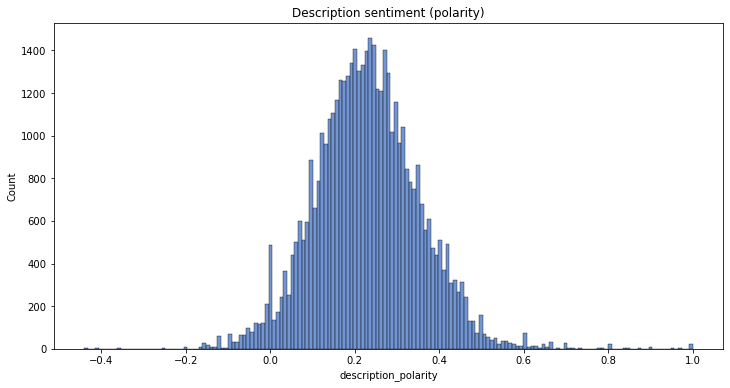

In [22]:
#histogram of description polarity

plt.figure(figsize=(12,6))

sn.histplot(x=data['description_polarity'], color='#4472C4')
plt.title('Description sentiment (polarity)')
plt.show()

In [23]:
#recategorization of variable description_polarity

data.loc[(data['description_language']!='es') & (data['description_language']!='en'), 'description_polarity_categorical'] = 'no_description_or_not_in_English_or_Spanish'
data.loc[(data['description_language']=='es'), 'description_polarity_categorical'] = 'description_in_Spanish'
data.loc[(data['description_polarity']<0.2), 'description_polarity_categorical'] = 'low_sentiment_<0.2'
data.loc[(data['description_polarity']>=0.2) & (data['description_polarity']<0.3), 'description_polarity_categorical'] = 'medium_sentiment_(0.2-0.29)'
data.loc[(data['description_polarity']>=0.3), 'description_polarity_categorical'] = 'high_sentiment_(0.3-1)'

data.drop(['description_polarity'], axis=1, inplace=True)

<Figure size 1080x720 with 0 Axes>

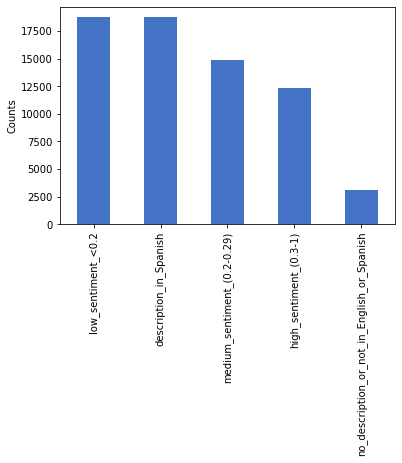

In [24]:
#column chart of new variable

fig = plt.figure(figsize = (15, 10))
fig, ax = plt.subplots()
data['description_polarity_categorical'].value_counts().plot(ax=ax, kind='bar',color='#4472C4', ylabel='Counts')

plt.show()

In [25]:
#One-hot encoding of variable description_polarity_categorical

data['description_polarity_categorical_'] = data['description_polarity_categorical']

data = pd.get_dummies(data, columns = ['description_polarity_categorical_'], prefix_sep = '', dtype='int64')

 - **host_number_of_days**
 
Creating new variable 'host_number_of_days' (the number of days host of the accommodation facility is an user of Airbnb) as a difference between values of variables last_scrapped and host_since.

count    67664.000000
mean      1959.962535
std       1030.787577
min          5.000000
25%       1055.000000
50%       1956.000000
75%       2847.000000
max       4827.000000
Name: host_number_of_days, dtype: float64


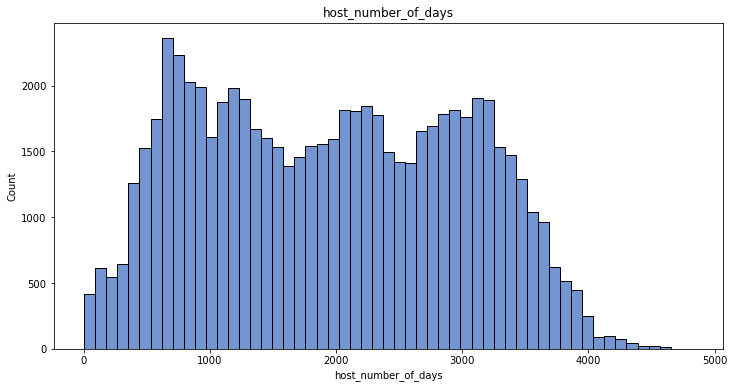

In [26]:
data['host_since'] = pd.to_datetime(data.host_since)
data['last_scraped'] = pd.to_datetime(data.last_scraped)

data['host_number_of_days'] = data['last_scraped'] - data['host_since']

data['host_number_of_days'] = data['host_number_of_days'].astype(str)
data['host_number_of_days'] = data['host_number_of_days'].str[:-5]
data['host_number_of_days'] = pd.to_numeric(data.host_number_of_days)

print(data['host_number_of_days'].describe())

plt.figure(figsize=(12,6))
sn.histplot(x=data['host_number_of_days'], color='#4472C4')
plt.title('host_number_of_days')
plt.show()

- **center_distance**

creating variable center_distance as a distance in kilometres between location of accommodation facility and city center of Barcelona. Vincenty's formula was used for the calculations, which takes into account the fact that the Earth has a geoid shape.

In [27]:
city_center = (41.387917, 2.169919)
data['center_distance'] = data.apply(lambda x: vincenty((x['latitude'], x['longitude']), city_center), axis=1)
data['center_distance'] = round(data['center_distance'], 3)

# 3. Missing values analysis <a class="anchor" id="Missing_values_analysis"></a>

Fraction of missing values for all variables was checked. In total 8 variables contained any missing values. Obsevations with missing values for variables 'host_is_superhost', 'host_identity_verified', 'bathrooms_text', 'host_since' and 'host_number_of_days' were removed. Blanks for variables 'first_review', 'last_review' and 'review_scores_rating' were left as these blanks contain important information thus these variables will be transformed in later stage.


In [28]:
data.isna().sum()/(len(data))

host_is_superhost                                                               0.001829
host_identity_verified                                                          0.001829
accommodates                                                                    0.000000
latitude                                                                        0.000000
longitude                                                                       0.000000
bathrooms_text                                                                  0.001106
minimum_nights                                                                  0.000000
maximum_nights                                                                  0.000000
availability_30                                                                 0.000000
availability_90                                                                 0.000000
number_of_reviews                                                               0.000000
instant_bookable     

In [29]:
data = data.dropna(subset=['host_is_superhost'])
data = data.dropna(subset=['host_identity_verified'])
data = data.dropna(subset=['host_number_of_days'])
data = data.dropna(subset=['host_since'])
data = data.dropna(subset=['bathrooms_text'])

# 4. Dataset restriction <a class="anchor" id="Dataset_restriction"></a>
The objective of this project is to predict prices for short-term rentals. In order to have appriopriate observarion in a dataset only accomodation facilities which can be rented for less than 30 days were left. Also in order to use only active Airbnb listing only object that can be rented in the upcoming 90 days were left. Described limitation of dataset was made using variables minimum_nights and availabiliy_90.


In [30]:
print(data.shape)
data = data.loc[(data['minimum_nights']<30)]
data = data.loc[(data['availability_90']>0)]
print(data.shape)

(67589, 37)
(32258, 37)


In [31]:
#There are 2 unusual values for variable 'maximum_nights' which are clearly errors - these observations were also removed

data = data.loc[(data['maximum_nights']!=2147483647)]

# 5. Cleaning and transformations of variables <a class="anchor" id="Cleaning_and_transformations_of_variables"></a>

In this part some variables were cleaned and transformed in order to be used in building machine learning model and/or to increase their predictive power.

## 5.1. Target variable <a class="anchor" id="Target_variable"></a>

Variable 'price' was first cleaned from unwanted characters and transformed to float type. Later outliers were removed and due to high postive skewnees log-transformation was performed.

In [32]:
print(data['price'].head(10))

0     $116.00
1      $80.00
2     $171.00
5     $146.00
6      $16.00
7      $14.00
8      $14.00
9      $18.00
10     $34.00
11     $32.00
Name: price, dtype: object


count    32256.000000
mean       119.750837
std        268.792715
min          8.000000
25%         46.000000
50%         86.000000
75%        131.000000
max      11500.000000
Name: price, dtype: float64


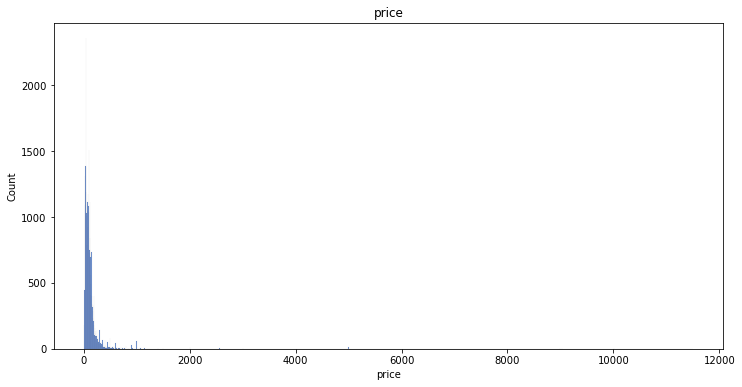

In [33]:
#removing '$' sign and ',' from price variable values and converting into float

data['price'] = data['price'].str.replace(r"$",'').str.replace(r",",'').astype(float)

print(data['price'].describe())

plt.figure(figsize=(12,6))
sn.histplot(x=data['price'], color='#4472C4')
plt.title('price')
plt.show()

Outlier value cut-off:  926.1289833621931
Number of outliers:  173
count    32083.000000
mean       107.696599
std         98.043378
min          8.000000
25%         46.000000
50%         86.000000
75%        130.000000
max        924.000000
Name: price, dtype: float64
Skewness:  3.2860716447895513


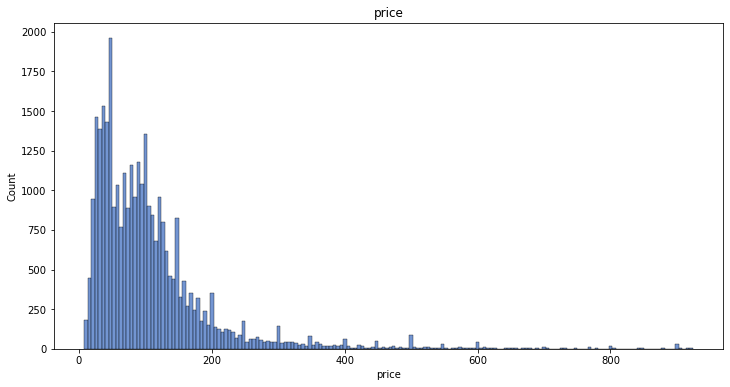

In [34]:
#removing outliers from dataset using 3 standard deviation rule

price_outliers_cutoff = data['price'].mean() + 3*data['price'].std()

print('Outlier value cut-off: ', price_outliers_cutoff)

print('Number of outliers: ', len(data.loc[(data['price']>= (data['price'].mean() + 3*data['price'].std()))]))

data = data.loc[(data['price']<price_outliers_cutoff)]

print(data['price'].describe())
print("Skewness: ", skew(data['price']))

plt.figure(figsize=(12,6))
sn.histplot(x=data['price'], color='#4472C4')
plt.title('price')
plt.show()

Skewness: 0.05766143407721348


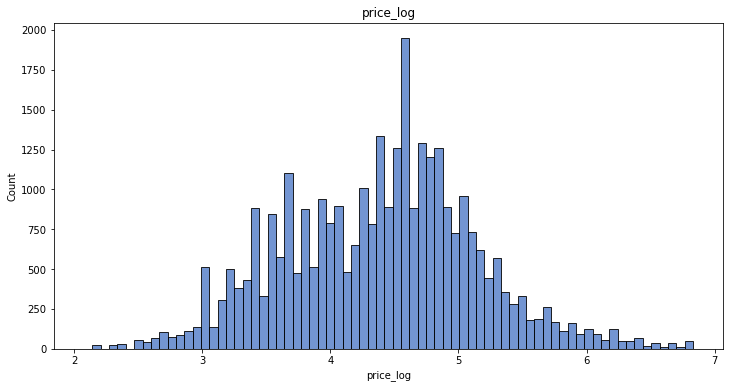

In [35]:
#price variable had still high positive skewnees after removing outliers, logarithmic tranformation was performed.
#Skewnees was reduced from 3.29 to 0.06, price_log was a variable finally used as a targer variable.

data['price_log']=np.log(data['price'])

print("Skewness:", skew(data['price_log']))

plt.figure(figsize=(12,6))
sn.histplot(x=data['price_log'], color='#4472C4')
plt.title('price_log')
plt.show()

## 5.2. Transformations of continous variables <a class="anchor" id="Transformations_of_continous_variables"></a>


- **calculated_host_listings_count**

Variable has high positive skewnees and over 25% of observations with value 1. It was decided to transform it into binary variable has_host_more_than_one_listing.

count    32083.000000
mean        16.279930
std         31.843297
min          1.000000
25%          1.000000
50%          3.000000
75%         14.000000
max        178.000000
Name: calculated_host_listings_count, dtype: float64


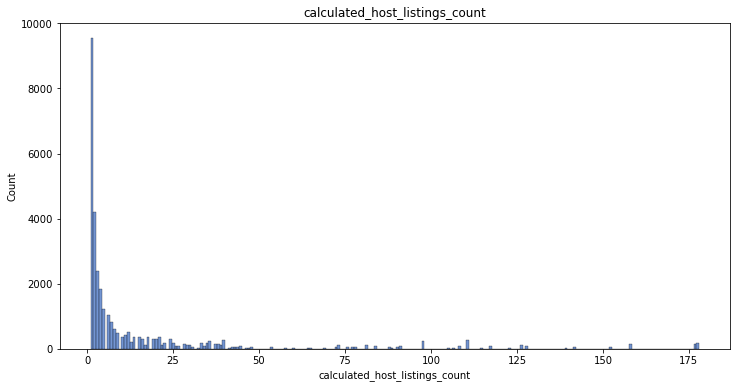

In [36]:
#descriptive statistics and histogram of calculated_host_listings_count

print(data['calculated_host_listings_count'].describe())

plt.figure(figsize=(12,6))
sn.histplot(x=data['calculated_host_listings_count'], color='#4472C4')
plt.title('calculated_host_listings_count')
plt.show()

In [37]:
#transforming calculated_host_listings_count into binary variable has_host_more_than_one_listing

data.loc[data['calculated_host_listings_count']==1,'has_host_more_than_one_listing'] = 0
data.loc[data['calculated_host_listings_count']>1, 'has_host_more_than_one_listing'] = 1

data['has_host_more_than_one_listing'].value_counts()/len(data)

1.0    0.702646
0.0    0.297354
Name: has_host_more_than_one_listing, dtype: float64

- **bathroom_text**

Variable bathrom text was converted from string to float type

In [38]:
#variable bathrooms_text is in string format, it was converted into float

print('Original bathroom_text value counts\n\n', data['bathrooms_text'].value_counts())

data.loc[data['bathrooms_text'] == 'Shared half-bath', 'bathrooms_text'] = '0.5'
data.loc[data['bathrooms_text'] == 'Half-bath', 'bathrooms_text'] = '0.5'
data.loc[data['bathrooms_text'] == 'Private half-bath', 'bathrooms_text'] = '0.5'

data['bathrooms_text'] = data['bathrooms_text'].str.replace(r"[a-zA-Z]",'').str.replace(r" ",'').astype(float)

print('After convertion bathroom_text value counts\n\n', data['bathrooms_text'].value_counts())

data.loc[(data['bathrooms_text']>data['accommodates']), 'bathrooms_text'] = data['accommodates']

data.loc[(data['bathrooms_text']<1), 'bathrooms_text'] = 1


Original bathroom_text value counts

 1 bath               11914
1 shared bath         6360
2 baths               5547
1 private bath        2675
1.5 shared baths      1657
1.5 baths             1352
2 shared baths         884
3 baths                518
2.5 baths              278
4 baths                208
2.5 shared baths       125
0 shared baths          88
3.5 baths               82
Shared half-bath        73
5 baths                 62
3 shared baths          48
5.5 baths               34
0 baths                 33
Half-bath               33
6 baths                 30
4 shared baths          23
4.5 baths               14
8 shared baths          13
5 shared baths           8
10 shared baths          4
7.5 baths                4
6 shared baths           4
8 baths                  4
Private half-bath        3
3.5 shared baths         2
5.5 shared baths         1
16 baths                 1
15 shared baths          1
Name: bathrooms_text, dtype: int64
After convertion bathroom_text value

- **number_of_reviews_l30d**

Variable has high skewness and majority of observations with value = 0, it was transformed into binary variable 'has_reviews_l30d.

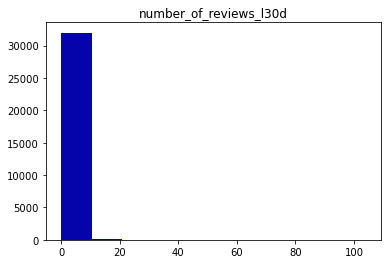

Skewness: 11.57372900034861


count    32083.000000
mean         0.729919
std          1.733605
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        104.000000
Name: number_of_reviews_l30d, dtype: float64

In [39]:
#histogram and descriptive statistics of number_of_reviews_l30d

plt.hist(x=data['number_of_reviews_l30d'], color='#0504aa')
plt.title('number_of_reviews_l30d')
plt.show()

print("Skewness:", skew(data['number_of_reviews_l30d']))

data['number_of_reviews_l30d'].describe()

In [40]:
#has_reviews_l30

#new binary variable made from initial variable number_of_reviews_l30d

data.loc[data['number_of_reviews_l30d']==0,'has_reviews_l30d'] = 0
data.loc[data['number_of_reviews_l30d']>0, 'has_reviews_l30d'] = 1

data['has_reviews_l30d'].value_counts()/len(data)

0.0    0.701057
1.0    0.298943
Name: has_reviews_l30d, dtype: float64

- **first_review** and **last_review**

Both variables were transformed into categorical to be able to use observations with missing values. It was checked that these missing values appear when number_of_reviews equal 0, thus they were transformed into category 'no reviews'.

In [41]:
#both variables have 18% of missing values, but they appear when number_of_reviews = 0

print(data['first_review'].isna().sum()/len(data))

print(data[['number_of_reviews']].loc[(data['first_review'].isnull())].number_of_reviews.value_counts())

print(data['last_review'].isna().sum()/len(data))

print(data[['number_of_reviews']].loc[(data['last_review'].isnull())].number_of_reviews.value_counts())

0.17875510394913194
0    5735
Name: number_of_reviews, dtype: int64
0.17875510394913194
0    5735
Name: number_of_reviews, dtype: int64


count    26348.000000
mean      1255.876537
std        863.128316
min          0.000000
25%        589.000000
50%       1082.000000
75%       1888.000000
max       4083.000000
Name: first_review_number_of_days_since, dtype: float64


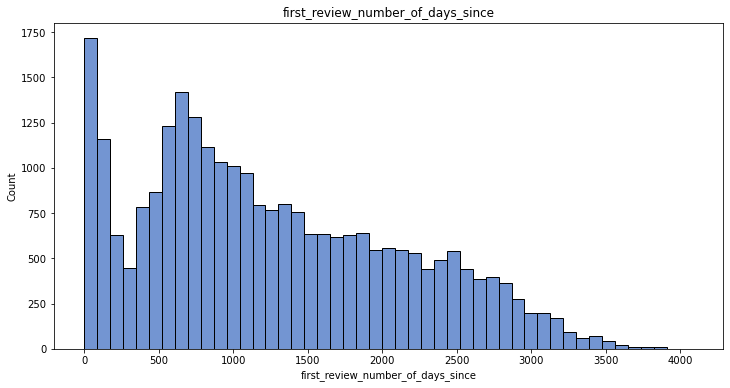

In [42]:
#first_review_number_of_days_since - new variable created as a difference between date of acquiring information
#regarding listing and date of first_review

data['first_review'] = pd.to_datetime(data.first_review)

data['first_review_number_of_days_since'] = data['last_scraped'] - data['first_review']

data['first_review_number_of_days_since'] = data['first_review_number_of_days_since'].astype(str)

data['first_review_number_of_days_since'] = data['first_review_number_of_days_since'].str[:-5]

data['first_review_number_of_days_since'] = pd.to_numeric(data.first_review_number_of_days_since)


print(data['first_review_number_of_days_since'].describe())

plt.figure(figsize=(12,6))
sn.histplot(x=data['first_review_number_of_days_since'], color='#4472C4')
plt.title('first_review_number_of_days_since')
plt.show()

In [43]:
#recategorization of variable first_review_number_of_days_since in order to be able to use observations with 0 reviews (NaN)

data.loc[data['first_review_number_of_days_since'].isnull(),'first_review_number_of_years_since'] = 'no_reviews'
data.loc[data['first_review_number_of_days_since']<730,'first_review_number_of_years_since'] = '<2'
data.loc[(data['first_review_number_of_days_since']>=730) & (data['first_review_number_of_days_since'] < 1825), 'first_review_number_of_years_since'] = '2-5'
data.loc[data['first_review_number_of_days_since']>=1825, 'first_review_number_of_years_since'] = '>5'

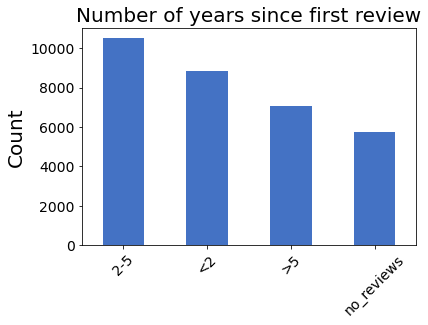

In [44]:
#column chart with counts of categories of new variable

fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = [10, 9]

data['first_review_number_of_years_since'].value_counts().plot(ax=ax, kind='bar',color='#4472C4')

plt.ylabel('Count', fontsize=20)

plt.title('Number of years since first review', fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation = 45)

plt.show()

count    26348.000000
mean       375.291369
std        390.342483
min          0.000000
25%         34.000000
50%        360.000000
75%        589.000000
max       3821.000000
Name: last_review_number_of_days_since, dtype: float64


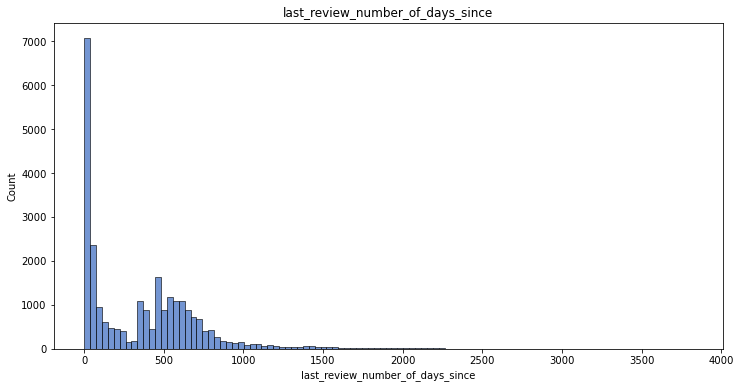

In [45]:
#last_review_number_of_days_since - new variable created in a same way as first_review_number_of_days_since

data['last_review'] = pd.to_datetime(data.last_review)

data['last_review_number_of_days_since'] = data['last_scraped'] - data['last_review']

data['last_review_number_of_days_since'] = data['last_review_number_of_days_since'].astype(str)

data['last_review_number_of_days_since'] = data['last_review_number_of_days_since'].str[:-5]

data['last_review_number_of_days_since'] = pd.to_numeric(data.last_review_number_of_days_since)

print(data['last_review_number_of_days_since'].describe())

plt.figure(figsize=(12,6))
sn.histplot(x=data['last_review_number_of_days_since'], color='#4472C4')
plt.title('last_review_number_of_days_since')
plt.show()

In [46]:
#recategorization of variable last_review_number_of_days_since in order to bea ble to use observations with 0 reviews (NaN)

data.loc[data['last_review_number_of_days_since'].isnull(),'last_review_number_of_years_since'] = 'no_reviews'
data.loc[data['last_review_number_of_days_since']<365,'last_review_number_of_years_since'] = '<1'
data.loc[(data['last_review_number_of_days_since']>=365) & (data['last_review_number_of_days_since'] < 730), 'last_review_number_of_years_since'] = '1-2'
data.loc[data['last_review_number_of_days_since']>=730, 'last_review_number_of_years_since'] = '>2'

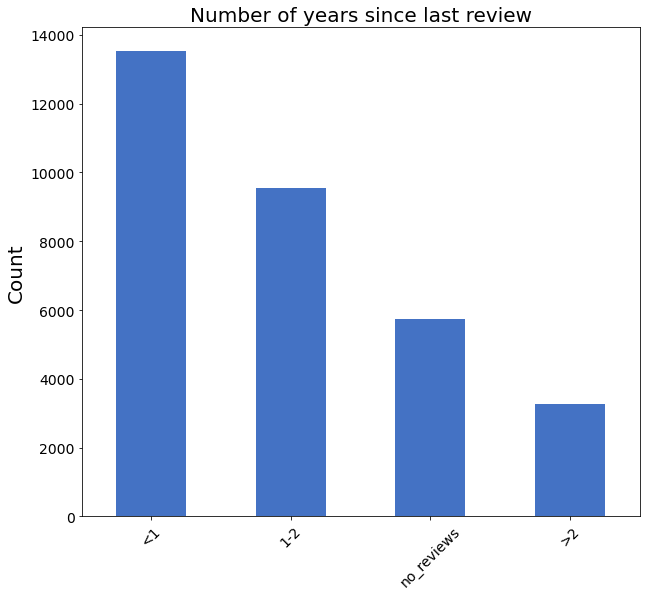

In [47]:
#column chart with counts of categories of new variable

fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = [10, 9]

data['last_review_number_of_years_since'].value_counts().plot(ax=ax, kind='bar',color='#4472C4')

plt.ylabel('Count', fontsize=20)

plt.title('Number of years since last review', fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation = 45)

plt.show()

- **review_score_rating**

Variable was transformed into categorical to be able to use observations with missing values. It was checked that these missing values appear almost always when number_of_reviews equal 0, thus they were transformed into category 'no reviews'.

In [48]:
#Variable has 18% of missing values, but they appear almost always when number_of_reviews = 0 - on Airbnb it is possible
#to give a review without score

print(data['review_scores_rating'].isna().sum()/len(data))

data[['number_of_reviews']].loc[(data['review_scores_rating'].isnull())].number_of_reviews.value_counts()

0.18112395972945172


0    5735
1      59
2      10
3       4
5       2
6       1
Name: number_of_reviews, dtype: int64

count    26272.000000
mean         4.528766
std          0.582130
min          0.000000
25%          4.400000
50%          4.650000
75%          4.850000
max          5.000000
Name: review_scores_rating, dtype: float64


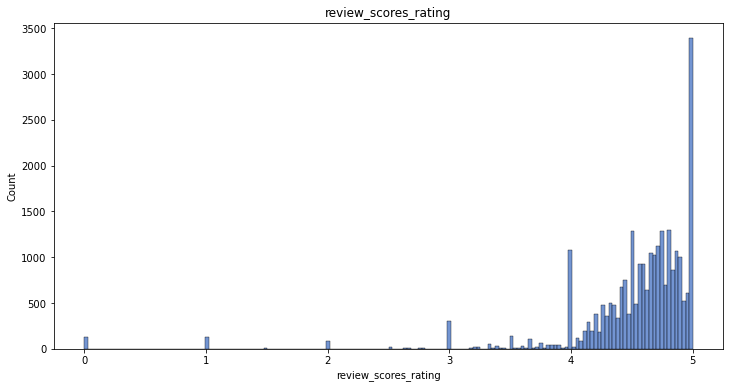

In [49]:
#descriptive statistics and histogram of variable review_scores_rating

print(data['review_scores_rating'].describe())

plt.figure(figsize=(12,6))
sn.histplot(x=data['review_scores_rating'], color='#4472C4')
plt.title('review_scores_rating')
plt.show()

In [50]:
#recategorization of variable review_scores_rating in order to be able to use observations with no score (NaN)

data.loc[data['review_scores_rating'].isnull(),'review_scores_rating_new'] = 'no_reviews'
data.loc[data['review_scores_rating']<=4,'review_scores_rating_new'] = '1.00-4.00'
data.loc[(data['review_scores_rating']>4) & (data['review_scores_rating'] <= 4.50), 'review_scores_rating_new'] = '4.01-4.50'
data.loc[(data['review_scores_rating']>4.50) & (data['review_scores_rating'] <= 4.80), 'review_scores_rating_new'] = '4.51-4.80'
data.loc[data['review_scores_rating']>4.80, 'review_scores_rating_new'] = '4.81-5.00'

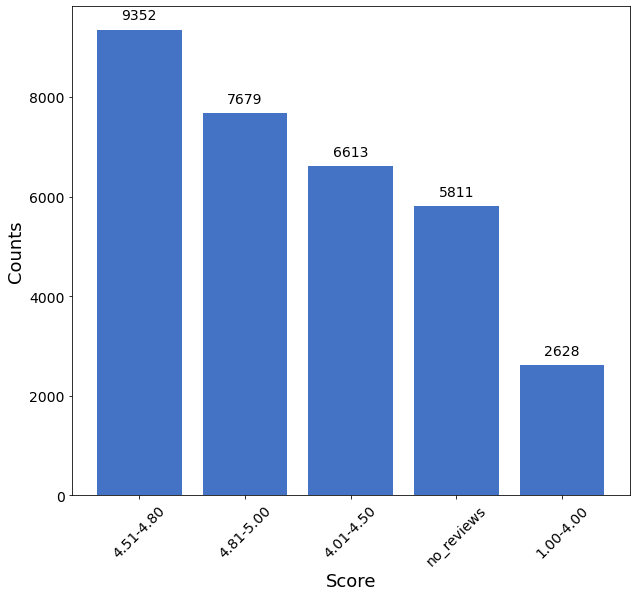

In [51]:
#column chart with counts of categories of new variable

review_scores_rating_value_counts_data = pd.DataFrame(data['review_scores_rating_new'].value_counts()).reset_index()
review_scores_rating_value_counts_data = review_scores_rating_value_counts_data.rename(columns={'index': 'category', 'review_scores_rating_new': 'counts'})

fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = [14, 10]

plt.bar(review_scores_rating_value_counts_data['category'], review_scores_rating_value_counts_data['counts'] ,color='#4472C4')

plt.ylabel('Counts', fontsize=18)
plt.xlabel('Score', fontsize=18)
#plt.grid(True)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation = 45)


for x,y in zip(review_scores_rating_value_counts_data['category'],review_scores_rating_value_counts_data['counts']):

    label = "{:}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                size = 14)

plt.show()

## 5.3. Transformations of other variables <a class="anchor" id="Transformations_of_other_variables"></a>

- **amenities**

Variable is stored as a list of string values closed with "" and separated by ',' representing which amenities are available in each accommodation facility. Few steps were performed in order to transform it into variables suitable for machine learning models.

In [52]:
#Firstly, one list containing values from all observarions was created in order to check value counts of each amenity

print(data['amenities'].head().values)

amenities_list = list(data.amenities)

amenities_list_string = " ".join(amenities_list)

amenities_list_string = amenities_list_string.replace('[', '').replace(']',',').replace('"','')

amenities_set = [x.strip() for x in amenities_list_string.split(',')]

len(amenities_set)

['["Hangers", "Free street parking", "Long term stays allowed", "Dedicated workspace", "TV", "Shampoo", "Kitchen", "Hot water", "Washer", "Elevator", "Hair dryer", "Iron", "Heating", "Crib", "Wifi", "Paid parking on premises", "Host greets you", "Air conditioning", "Essentials"]'
 '["Long term stays allowed", "Carbon monoxide alarm", "TV", "Kitchen", "Fire extinguisher", "Washer", "Smoke alarm", "Elevator", "Heating", "Cable TV", "Wifi", "Dryer", "Air conditioning", "Essentials"]'
 '["Elevator", "Luggage dropoff allowed", "Wifi", "Coffee maker", "Host greets you", "Long term stays allowed", "Dedicated workspace", "TV", "Paid parking off premises", "Kitchen", "Smoke alarm", "Fire extinguisher", "Refrigerator", "Hair dryer", "Microwave", "Crib", "Pack \\u2019n Play/travel crib", "High chair", "Hangers", "Stove", "Dishwasher", "Washer", "Oven", "Iron", "Paid parking on premises", "Dryer", "Cooking basics", "Shampoo", "Patio or balcony", "Hot water", "Dishes and silverware", "Heating", "Be

739123

In [53]:
#Frequencies of amenities available in accommodation facilities

pd.Series(amenities_set).value_counts()/len(data)

Wifi                                                                                       0.958077
Essentials                                                                                 0.915313
Long term stays allowed                                                                    0.888321
Hair dryer                                                                                 0.843469
Kitchen                                                                                    0.835271
Hangers                                                                                    0.793504
Heating                                                                                    0.782876
Iron                                                                                       0.782252
Washer                                                                                     0.724402
Hot water                                                                                  0.687872


In [54]:
#Finally, 24 amenities were selected with value counts between 5% and 95% and considered as the ones that can have impact
#on price. Some of them were grouped into one category. In total 24 binary variables were created with value 1 if amenity
#is present and 0 if not. Some similar amenities were grouped together into one category.

data.loc[data['amenities'].str.contains('Central air conditioning|Air conditioning'), 'amenity_air_conditioning'] = 1
data.loc[data['amenities'].str.contains('Bathtub'), 'amenity_bathtub'] = 1
data.loc[data['amenities'].str.contains('Bed linens|Bed sheets'), 'amenity_bed_linens'] = 1
data.loc[data['amenities'].str.contains('Breakfast|breakfast'), 'amenity_breakfast'] = 1
data.loc[data['amenities'].str.contains('Nespresso machine|Coffee maker|coffee'), 'amenity_coffee_maker'] = 1
data.loc[data['amenities'].str.contains('Cooking basics'), 'amenity_cooking_basics'] = 1
data.loc[data['amenities'].str.contains('Crib'), 'amenity_crib'] = 1
data.loc[data['amenities'].str.contains('Dishwasher'), 'amenity_dishwasher'] = 1
data.loc[data['amenities'].str.contains('Elevator'), 'amenity_elevator'] = 1
data.loc[data['amenities'].str.contains('Free parking|Free street parking|Free driveway parking'), 'amenity_free_parking'] = 1
data.loc[data['amenities'].str.contains('Hair dryer'), 'amenity_hair_dryer'] = 1
data.loc[data['amenities'].str.contains('Hangers'), 'amenity_hangers'] = 1
data.loc[data['amenities'].str.contains('Heating|Central heating|Portable heater|Radiant heating'), 'amenity_heating'] = 1
data.loc[data['amenities'].str.contains('Iron'), 'amenity_iron'] = 1
data.loc[data['amenities'].str.contains('Kitchen|kitchen'), 'amenity_kitchen'] = 1
data.loc[data['amenities'].str.contains('Long term stays allowed'), 'amenity_long_term_stays_allowed'] = 1
data.loc[data['amenities'].str.contains('Luggage dropoff allowed'), 'amenity_luggage_dropoff_allowed'] = 1
data.loc[data['amenities'].str.contains('Microwave'), 'amenity_microwave'] = 1
data.loc[data['amenities'].str.contains('balcony|Balcony|Terrace|Backyard|backyard|Garden|garden'), 'amenity_outdoor_space'] = 1
data.loc[data['amenities'].str.contains('Oven|oven'), 'amenity_oven'] = 1
data.loc[data['amenities'].str.contains('Paid parking|Paid street parking'), 'amenity_paid_parking'] = 1
data.loc[data['amenities'].str.contains('refrigerator|Refrigerator'), 'amenity_refrigerator'] = 1
data.loc[data['amenities'].str.contains('Toaster'), 'amenity_toaster'] = 1
data.loc[data['amenities'].str.contains('tv|TV'), 'amenity_tv'] = 1

data['amenity_air_conditioning'] = data['amenity_air_conditioning'].fillna(0)
data['amenity_bathtub'] = data['amenity_bathtub'].fillna(0)
data['amenity_bed_linens'] = data['amenity_bed_linens'].fillna(0)
data['amenity_breakfast'] = data['amenity_breakfast'].fillna(0)
data['amenity_coffee_maker'] = data['amenity_coffee_maker'].fillna(0)
data['amenity_cooking_basics'] = data['amenity_cooking_basics'].fillna(0)
data['amenity_crib'] = data['amenity_crib'].fillna(0)
data['amenity_dishwasher'] = data['amenity_dishwasher'].fillna(0)
data['amenity_elevator'] = data['amenity_elevator'].fillna(0)
data['amenity_free_parking'] = data['amenity_free_parking'].fillna(0)
data['amenity_hair_dryer'] = data['amenity_hair_dryer'].fillna(0)
data['amenity_hangers'] = data['amenity_hangers'].fillna(0)
data['amenity_heating'] = data['amenity_heating'].fillna(0)
data['amenity_iron'] = data['amenity_iron'].fillna(0)
data['amenity_kitchen'] = data['amenity_kitchen'].fillna(0)
data['amenity_long_term_stays_allowed'] = data['amenity_long_term_stays_allowed'].fillna(0)
data['amenity_luggage_dropoff_allowed'] = data['amenity_luggage_dropoff_allowed'].fillna(0)
data['amenity_microwave'] = data['amenity_microwave'].fillna(0)
data['amenity_outdoor_space'] = data['amenity_outdoor_space'].fillna(0)
data['amenity_oven'] = data['amenity_oven'].fillna(0)
data['amenity_paid_parking'] = data['amenity_paid_parking'].fillna(0)
data['amenity_refrigerator'] = data['amenity_refrigerator'].fillna(0)
data['amenity_toaster'] = data['amenity_toaster'].fillna(0)
data['amenity_tv'] = data['amenity_tv'].fillna(0)

In [55]:
#Frequencies of each amenity

col_names_amenities = data.iloc[:,43:].columns

data[col_names_amenities].mean().sort_values(ascending = False)

amenity_long_term_stays_allowed    0.888321
amenity_kitchen                    0.847708
amenity_hair_dryer                 0.843469
amenity_heating                    0.810616
amenity_hangers                    0.793504
amenity_iron                       0.782252
amenity_tv                         0.772185
amenity_air_conditioning           0.703457
amenity_refrigerator               0.603279
amenity_elevator                   0.580619
amenity_coffee_maker               0.572858
amenity_microwave                  0.568681
amenity_cooking_basics             0.553720
amenity_bed_linens                 0.527289
amenity_oven                       0.457252
amenity_outdoor_space              0.387775
amenity_paid_parking               0.381417
amenity_dishwasher                 0.314715
amenity_crib                       0.285042
amenity_luggage_dropoff_allowed    0.241592
amenity_free_parking               0.100739
amenity_bathtub                    0.089892
amenity_toaster                 

- **host_is_superhost**, **host_identity_verified**, **instant_bookable**

Binary variales were recoded from string to numeric type to be suitable for creating XGBoost model.

In [56]:
#frequencies of binary variables and recoding into 1/0 values - needed for creating XGBoost model

print(data['host_is_superhost'].value_counts()/len(data))
print(data['host_identity_verified'].value_counts()/len(data))
print(data['instant_bookable'].value_counts()/len(data))

host_is_superhost_dict = {'t':1,'f':0}
data.host_is_superhost = data.host_is_superhost.map(host_is_superhost_dict)

host_identity_verified_dict = {'t':1,'f':0}
data.host_identity_verified = data.host_identity_verified.map(host_identity_verified_dict)

instant_bookable_dict = {'t':1,'f':0}
data.instant_bookable = data.instant_bookable.map(instant_bookable_dict)

f    0.805536
t    0.194464
Name: host_is_superhost, dtype: float64
t    0.821868
f    0.178132
Name: host_identity_verified, dtype: float64
t    0.515507
f    0.484493
Name: instant_bookable, dtype: float64


- **categorical variables**

All categorical variables were transformed using one-hot encoding.

In [57]:
#One-hot encoding of categorical variables

data = pd.get_dummies(data, columns = ['neighbourhood_group_cleansed'], prefix_sep = '_', dtype='int64')
data = pd.get_dummies(data, columns = ['room_type'], prefix_sep = '_', dtype='int64')
data = pd.get_dummies(data, columns = ['first_review_number_of_years_since'], prefix_sep = '_', dtype='int64')
data = pd.get_dummies(data, columns = ['last_review_number_of_years_since'], prefix_sep = '_', dtype='int64')
data = pd.get_dummies(data, columns = ['quarter'], prefix_sep = '_', dtype='int64')
data = pd.get_dummies(data, columns = ['review_scores_rating_new'], prefix_sep='_', dtype='int64')

In [58]:
#Chosing final set of variables for creating XGBoost model - excluding the ones that were transformed

data_model = data[[
 'host_is_superhost',
 'host_identity_verified',
 'accommodates',
 'bathrooms_text',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'number_of_reviews',
 'instant_bookable',
 'host_number_of_days',
 'center_distance',
 'price_log',
 'has_host_more_than_one_listing',
 'has_reviews_l30d',
 'amenity_air_conditioning',
 'amenity_bathtub',
 'amenity_bed_linens',
 'amenity_breakfast',
 'amenity_coffee_maker',
 'amenity_cooking_basics',
 'amenity_crib',
 'amenity_dishwasher',
 'amenity_elevator',
 'amenity_free_parking',
 'amenity_hair_dryer',
 'amenity_hangers',
 'amenity_heating',
 'amenity_iron',
 'amenity_kitchen',
 'amenity_long_term_stays_allowed',
 'amenity_luggage_dropoff_allowed',
 'amenity_microwave',
 'amenity_outdoor_space',
 'amenity_oven',
 'amenity_paid_parking',
 'amenity_refrigerator',
 'amenity_toaster',
 'amenity_tv',
 'neighbourhood_group_cleansed_Ciutat Vella',
 'neighbourhood_group_cleansed_Eixample',
 'neighbourhood_group_cleansed_Gràcia',
 'neighbourhood_group_cleansed_Horta-Guinardó',
 'neighbourhood_group_cleansed_Les Corts',
 'neighbourhood_group_cleansed_Nou Barris',
 'neighbourhood_group_cleansed_Sant Andreu',
 'neighbourhood_group_cleansed_Sant Martí',
 'neighbourhood_group_cleansed_Sants-Montjuïc',
 'neighbourhood_group_cleansed_Sarrià-Sant Gervasi',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'first_review_number_of_years_since_2-5',
 'first_review_number_of_years_since_<2',
 'first_review_number_of_years_since_>5',
 'first_review_number_of_years_since_no_reviews',
 'last_review_number_of_years_since_1-2',
 'last_review_number_of_years_since_<1',
 'last_review_number_of_years_since_>2',
 'last_review_number_of_years_since_no_reviews',
 'quarter_Q1',
 'quarter_Q2',
 'quarter_Q3',
 'review_scores_rating_new_1.00-4.00',
 'review_scores_rating_new_4.01-4.50',
 'review_scores_rating_new_4.51-4.80',
 'review_scores_rating_new_4.81-5.00',
 'review_scores_rating_new_no_reviews',
 'description_polarity_categorical_description_in_Spanish',
 'description_polarity_categorical_high_sentiment_(0.3-1)',
 'description_polarity_categorical_low_sentiment_<0.2',
 'description_polarity_categorical_medium_sentiment_(0.2-0.29)',
 'description_polarity_categorical_no_description_or_not_in_English_or_Spanish']]

In [59]:
#final dataset shape

data_model.shape

(32083, 73)

In [60]:
#saving final dataset which will be used for creating XGBoost model

data_model.to_csv(r'C:\Kuba\github\Airbnb Barcelona\data\data_model.csv')

# 6. Building XGBoost models <a class="anchor" id="Building_XGBoost_models"></a>

## 6.1. Dataset split and hyperparameters tuning <a class="anchor" id="Dataset_split_and_hyperparameters_tuning"></a>
In this part XGBoost models were built with goal of predicting price of Airbnb properties. Firstly, dataset was split into train set (80%) and validation set (20%). Then, hypeparparemeter tuning was performed on 4 hyperparameters of the model: max_depth, learning_rate, colsample_bytree and subsample. Models with each combination of below values for these hyperparameters were built:

**max_depth_values** = [7, 8, 9, 10, 11]

**learning_rate_values** = [0.05, 0.1, 0.2]

**colsample_bytree_values** = [0.6, 0.7, 0.8, 0.9, 1]

**subsample_values** = [0.6, 0.7, 0.8, 0.9, 1]

Also, constant values for some of the hyperparameters were selected:

**n_estimators** = 700

**min_child_weight** = 10

**lambda** = 30

Values for all other hyperparameters were set to default. In total 375 models were built. For each model R2 score and error metric MAPE (Mean Absolute Percentage Error) on training and validation set were calculated. This error metric was chosen because of its quick and convienient interpretability.

In [61]:
#renaming some of the variable names because XGBoost does not accept variable names with characters like '<', '>' and spaces

data_model.rename(columns={
    'neighbourhood_group_cleansed_Ciutat Vella': 'neighbourhood_group_cleansed_Ciutat_Vella',
    'neighbourhood_group_cleansed_Les Corts': 'neighbourhood_group_cleansed_Les_Corts',
    'neighbourhood_group_cleansed_Nou Barris': 'neighbourhood_group_cleansed_Nou_Barris',
    'neighbourhood_group_cleansed_Sant Andreu': 'neighbourhood_group_cleansed_Sant_Andreu',
    'neighbourhood_group_cleansed_Sant Martí': 'neighbourhood_group_cleansed_Sant_Martí',
    'neighbourhood_group_cleansed_Sarrià-Sant Gervasi': 'neighbourhood_group_cleansed_Sarrià_Sant_Gervasi',
    'room_type_Entire home/apt': 'room_type_Entire_home/apt',
    'room_type_Hotel room': 'room_type_Hotel_room',
    'room_type_Private room': 'room_type_Private_room',
    'room_type_Shared room': 'room_type_Shared_room',
    'first_review_number_of_years_since_<2': 'first_review_number_of_years_since_lt2',
    'first_review_number_of_years_since_>5': 'first_review_number_of_years_since_gt5',
    'last_review_number_of_years_since_<1': 'last_review_number_of_years_since_lt1',
    'last_review_number_of_years_since_>2': 'last_review_number_of_years_since_gt2',
    'description_polarity_categorical_low_sentiment_<0.2': 'description_polarity_categorical_low_sentiment_lt0.2'
},
          inplace=True)

C:\Kuba\programy\Anaconda\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [62]:
#data split into train set and validation set

X = data_model.drop('price_log', axis=1).copy()
y = data_model.price_log.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

In [63]:
#number of observations in each set

print('X_train observations:', X_train.shape[0])
print('X_test observations:', X_test.shape[0])

X_train observations: 25666
X_test observations: 6417


In [64]:
#function to calculate error metric for models (MAPE - Mean Absolute Percentage Error)

def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

In [65]:
#building 375 models with each combination of values for 4 tuned hyperparameters

max_depth_values = [7,8,9,10,11]
learning_rate_values = [0.05, 0.1, 0.2]
colsample_bytree_values = [0.6, 0.7, 0.8, 0.9, 1]
subsample_values = [0.6, 0.7, 0.8, 0.9, 1]

max_depth = []
learning_rate = []
colsample_bytree = []
subsample = []

training_mean_squared_error = []
validation_mean_squared_error = []

training_mean_absolute_percentage_error = []
validation_mean_absolute_percentage_error = []

training_r2 = []
validation_r2 = []

model_number = 1

for d in max_depth_values:
    for l in learning_rate_values:
        for c in colsample_bytree_values:
            for s in subsample_values:
                xgb_reg = xgb.XGBRegressor(seed = 123, max_depth = d, learning_rate = l, n_estimators = 700, colsample_bytree = c, subsample = s, min_child_weight = 10, reg_lambda = 30)
                xgb_reg.fit(X_train, y_train, verbose = True)
                training_preds_xgb_reg = xgb_reg.predict(X_train)
                val_preds_xgb_reg = xgb_reg.predict(X_test)

                training_preds_xgb_reg_exp = np.exp(training_preds_xgb_reg)
                y_train_exp = np.exp(y_train)

                val_preds_xgb_reg_exp = np.exp(val_preds_xgb_reg)
                y_test_exp = np.exp(y_test)

                max_depth.append(d)
                learning_rate.append(l)
                colsample_bytree.append(c)
                subsample.append(s)
             

                training_mean_squared_error.append(round(mean_squared_error(y_train_exp, training_preds_xgb_reg_exp),4))
                validation_mean_squared_error.append(round(mean_squared_error(y_test_exp, val_preds_xgb_reg_exp),4))

                training_mean_absolute_percentage_error.append(round(mape(y_train_exp, training_preds_xgb_reg_exp),4))
                validation_mean_absolute_percentage_error.append(round(mape(y_test_exp, val_preds_xgb_reg_exp),4))

                training_r2.append(round(r2_score(y_train_exp, training_preds_xgb_reg_exp),4))
                validation_r2.append(round(r2_score(y_test_exp, val_preds_xgb_reg_exp),4))

                print(model_number)
                model_number += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [66]:
#results of the models were stored into dataframe and saved into csv file

XGBoost_results = pd.DataFrame(
    {'max_depth': max_depth,
     'learning_rate': learning_rate,
     'colsample_bytree': colsample_bytree,
     'subsample': subsample,
     'training_mean_absolute_percentage_error': training_mean_absolute_percentage_error,
     'validation_mean_absolute_percentage_error': validation_mean_absolute_percentage_error,
     'training_r2': training_r2,
     'validation_r2': validation_r2    
})

XGBoost_results.to_csv(r'C:\Kuba\github\Airbnb Barcelona\model\model_score.csv')

## 6.2. Comparing results of different models <a class="anchor" id="Comparing_results_of_different_models"></a>
In this part values of error metrics of built models were aggregated to show how average MAPE varies with different values of tuned hypeparameters.

- **max_depth**

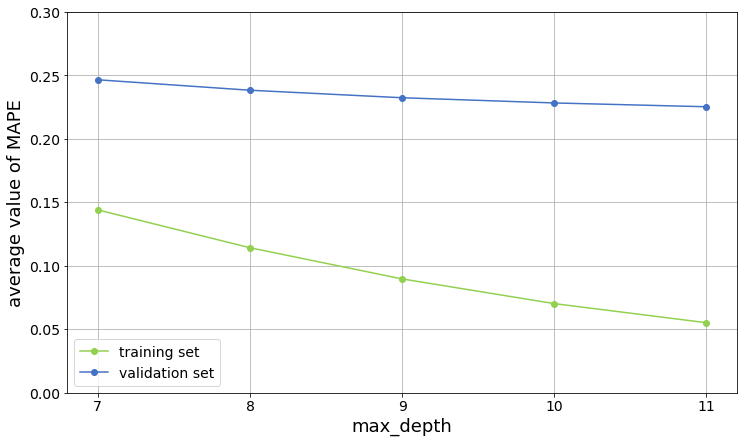

In [67]:
#chart presenting average values of MAPE for models with different values of max_depth

XGBoost_results_by_max_depth = XGBoost_results.groupby(['max_depth'], as_index=False).agg({'validation_mean_absolute_percentage_error': 'mean', 'training_mean_absolute_percentage_error': 'mean'})

plt.rcParams["figure.figsize"] = (12,7)

plt.plot(XGBoost_results_by_max_depth['max_depth'], XGBoost_results_by_max_depth['training_mean_absolute_percentage_error'], color='#92D050', marker='o')
plt.plot(XGBoost_results_by_max_depth['max_depth'], XGBoost_results_by_max_depth['validation_mean_absolute_percentage_error'], color='#4472C4', marker='o')

plt.xlabel('max_depth', fontsize=18)
plt.ylabel('average value of MAPE', fontsize=18)
plt.gca().legend(('training set', 'validation set'), loc='lower left', fontsize=14)
#
plt.ylim(0,0.30)
plt.xticks([7,8,9,10,11])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

- **learning_rate**

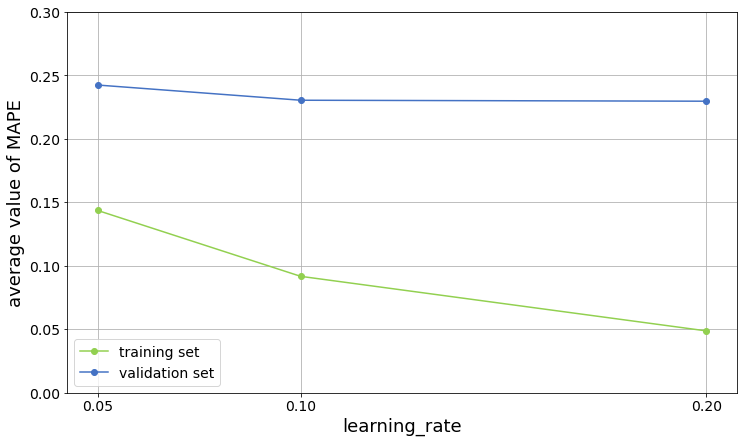

In [68]:
#chart presenting average values of MAPE for models with different values of learning_rate

XGBoost_results_by_learning_rate = XGBoost_results.groupby(['learning_rate'], as_index=False).agg({'validation_mean_absolute_percentage_error': 'mean', 'training_mean_absolute_percentage_error': 'mean'})

plt.rcParams["figure.figsize"] = (12,7)

plt.plot(XGBoost_results_by_learning_rate['learning_rate'], XGBoost_results_by_learning_rate['training_mean_absolute_percentage_error'], color='#92D050', marker='o')
plt.plot(XGBoost_results_by_learning_rate['learning_rate'], XGBoost_results_by_learning_rate['validation_mean_absolute_percentage_error'], color='#4472C4', marker='o')

plt.xlabel('learning_rate', fontsize=18)
plt.ylabel('average value of MAPE', fontsize=18)
plt.gca().legend(('training set', 'validation set'), loc='lower left', fontsize=14)

plt.ylim(0,0.30)
plt.xticks([0.05,0.1,0.2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

- **subsample**

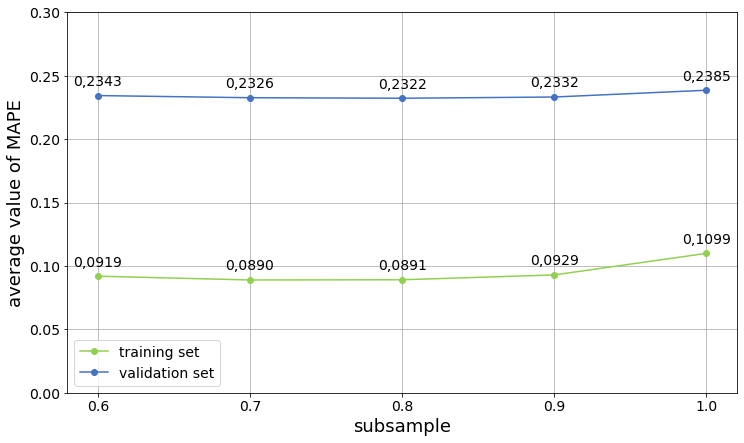

In [69]:
#chart presenting average values of MAPE for models with different values of subsample

XGBoost_results_by_subsample = XGBoost_results.groupby(['subsample'], as_index=False).agg({'validation_mean_absolute_percentage_error': 'mean', 'training_mean_absolute_percentage_error': 'mean'})

plt.rcParams["figure.figsize"] = (12,7)

plt.plot(XGBoost_results_by_subsample['subsample'], XGBoost_results_by_subsample['training_mean_absolute_percentage_error'], color='#92D050', marker='o')
plt.plot(XGBoost_results_by_subsample['subsample'], XGBoost_results_by_subsample['validation_mean_absolute_percentage_error'], color='#4472C4', marker='o')
plt.xlabel('subsample', fontsize=18)
plt.ylabel('average value of MAPE', fontsize=18)
plt.gca().legend(('training set', 'validation set'), loc='lower left', fontsize=14)
plt.ylim(0,0.30)
plt.xticks([0.6, 0.7, 0.8, 0.9, 1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)


for x,y in zip(XGBoost_results_by_subsample['subsample'],XGBoost_results_by_subsample['training_mean_absolute_percentage_error']):

    label = "{:.4f}".format(y).replace('.',',')

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                size = 14)
    

for x,y in zip(XGBoost_results_by_subsample['subsample'],XGBoost_results_by_subsample['validation_mean_absolute_percentage_error']):

    label = "{:.4f}".format(y).replace('.',',')

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                size = 14)


- **colsample_bytree**

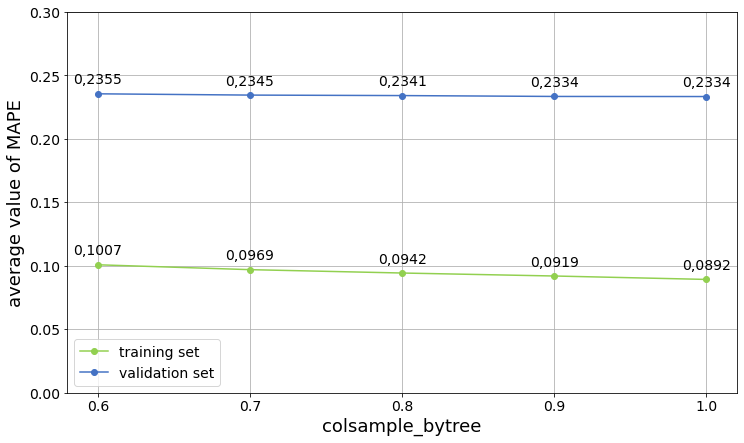

In [70]:
#chart presenting average values of MAPE for models with different values of colsample_bytree

XGBoost_results_by_colsample = XGBoost_results.groupby(['colsample_bytree'], as_index=False).agg({'validation_mean_absolute_percentage_error': 'mean', 'training_mean_absolute_percentage_error': 'mean'})

plt.rcParams["figure.figsize"] = (12,7)

plt.plot(XGBoost_results_by_colsample['colsample_bytree'], XGBoost_results_by_colsample['training_mean_absolute_percentage_error'], color='#92D050', marker='o')
plt.plot(XGBoost_results_by_colsample['colsample_bytree'], XGBoost_results_by_colsample['validation_mean_absolute_percentage_error'], color='#4472C4', marker='o')
plt.xlabel('colsample_bytree', fontsize=18)
plt.ylabel('average value of MAPE', fontsize=18)
plt.gca().legend(('training set', 'validation set'), loc='lower left', fontsize=14)
plt.ylim(0,0.30)
plt.xticks([0.6, 0.7, 0.8, 0.9, 1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)


for x,y in zip(XGBoost_results_by_colsample['colsample_bytree'],XGBoost_results_by_colsample['training_mean_absolute_percentage_error']):

    label = "{:.4f}".format(y).format(y).replace('.',',')


    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                size = 14)
    

for x,y in zip(XGBoost_results_by_colsample['colsample_bytree'],XGBoost_results_by_colsample['validation_mean_absolute_percentage_error']):

    label = "{:.4f}".format(y).format(y).replace('.',',')


    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                size = 14)

## 6.3. Selecting final model <a class="anchor" id="Selecting_final_model"></a>

One final model was selected due to established criteria. Only models that showed certain level of stability of prediction between training and validation set were considered. For this purpose, the difference in MAPE between the two sets was used, and its maximum value was set to 0.15. There were in total 223 such models. From this group model with the lowest MAPE on validation set was selected. Values of tuned hyperparamters for final model were as follow:

**max_depth_values** = 11

**learning_rate_values** = 0.05

**colsample_bytree_values** = 1

**subsample_values** = 0.7


In [71]:
#selecting models were variance of MAPE between sets was < 0.15

XGBoost_results_low_variance = XGBoost_results.copy()
XGBoost_results_low_variance = XGBoost_results_low_variance.loc[XGBoost_results_low_variance['validation_mean_absolute_percentage_error'] - XGBoost_results_low_variance['training_mean_absolute_percentage_error'] < 0.15]
len(XGBoost_results_low_variance)

223

In [72]:
#selecting model with lowest MAPE on validation set

XGBoost_results_low_variance.loc[XGBoost_results_low_variance['validation_mean_absolute_percentage_error'] == XGBoost_results_low_variance['validation_mean_absolute_percentage_error'].min()]

,max_depth,learning_rate,colsample_bytree,subsample,training_mean_absolute_percentage_error,validation_mean_absolute_percentage_error,training_r2,validation_r2
321,11,0.05,1.0,0.7,0.086,0.2244,0.9334,0.7246


## 6.4. Model evaluation <a class="anchor" id="Model_evaluation"></a>

Final model had MAPE equal to 0.2244, which means that on average values of predictions were different from actual values by 22.44%. This value of MAPE can be considered as acceptable, close to the value below 20% which is considered as good.

In [73]:
#building final model

xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(seed=123, max_depth=11, learning_rate=0.05,  n_estimators=700, colsample_bytree = 1, subsample = 0.7, min_child_weight = 10,  reg_lambda = 30)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

training_preds_xgb_reg_exp = np.exp(training_preds_xgb_reg)
y_train_exp = np.exp(y_train)

val_preds_xgb_reg_exp = np.exp(val_preds_xgb_reg)
y_test_exp = np.exp(y_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MAPE:", round(mape(y_train_exp, training_preds_xgb_reg_exp),4))
print("Validation MAPE:", round(mape(y_test_exp, val_preds_xgb_reg_exp),4))
print("\nTraining r2:", round(r2_score(y_train_exp, training_preds_xgb_reg_exp),4))
print("Validation r2:", round(r2_score(y_test_exp, val_preds_xgb_reg_exp),4))

Time taken to run: 1.3 minutes

Training MAPE: 0.086
Validation MAPE: 0.2244

Training r2: 0.9334
Validation r2: 0.7246


### 6.4.1. Feature importance <a class="anchor" id="Feature_importance"></a>
Feature importance is calculated based on how important were splits of dataset made by each variable in the process of bulding individual XGBoost trees. Weights of variables were scaled so they sum up to 1. Among 10 most important features were all 4 variables created from variable room_type, maximum number of guests, number of bathrooms, presence of air conditioning as well as location of property in neighbourhoods Sant Andreu and Nou Barris.

In [74]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg

,weight
room_type_Entire_home/apt,0.355689
room_type_Private_room,0.161989
room_type_Shared_room,0.066169
accommodates,0.032913
room_type_Hotel_room,0.017673
amenity_air_conditioning,0.017305
quarter_Q1,0.013184
bathrooms_text,0.011436
neighbourhood_group_cleansed_Sant_Andreu,0.010570
neighbourhood_group_cleansed_Nou_Barris,0.010458


### 6.4.2. Partial dependence plots <a class="anchor" id="Partial_dependence_plots"></a>

For selected continuous explanatory variables, it was examined how a change in their values would affect the prediction of the explanatory variable, assuming constant values of the other variables. The average prediction values were then plotted on partial dependence charts. It was created for variables: accommodates, minimum_nights, center_distance and number_of_reviews.

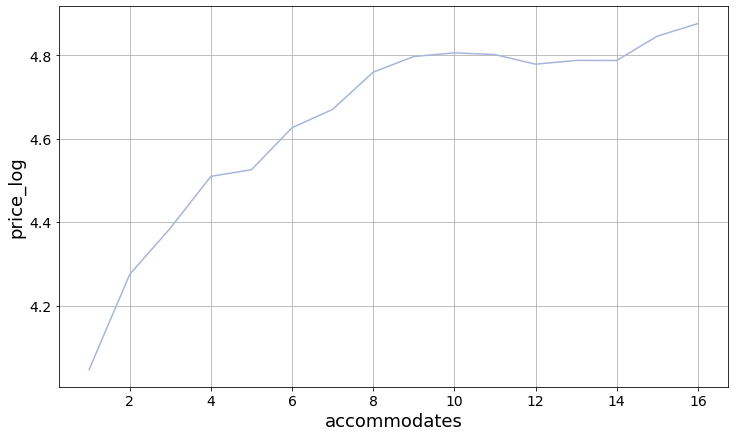

In [75]:
#partial dependence plot for 'accommodates'

partial_dependence_accommodates = partial_dependence(xgb_reg, X_train, ['accommodates'])

pd_accommodates_average = partial_dependence_accommodates['average'].tolist()[0]
pd_accommodates_values = partial_dependence_accommodates['values'][0].tolist()

plt.rcParams["figure.figsize"] = (12,7)

plt.plot(pd_accommodates_values, pd_accommodates_average, color='#A7B5DB')
plt.ylabel('price_log', fontsize=18)
plt.xlabel('accommodates', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

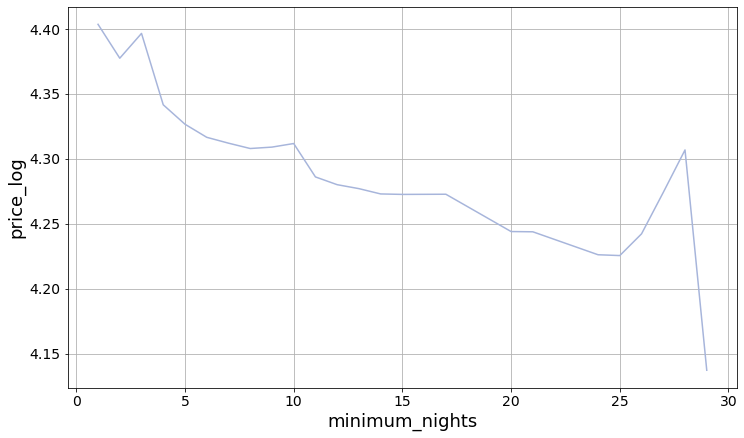

In [76]:
#partial dependence plot for 'minimum_nights'

partial_dependence_minimum_nights = partial_dependence(xgb_reg, X_train, ['minimum_nights'])
pd_minimum_nights_average = partial_dependence_minimum_nights['average'].tolist()[0]
pd_minimum_nights_values = partial_dependence_minimum_nights['values'][0].tolist()

plt.rcParams["figure.figsize"] = (12,7)

plt.plot(pd_minimum_nights_values, pd_minimum_nights_average, color='#A7B5DB')
plt.ylabel('price_log', fontsize=18)
plt.xlabel('minimum_nights', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

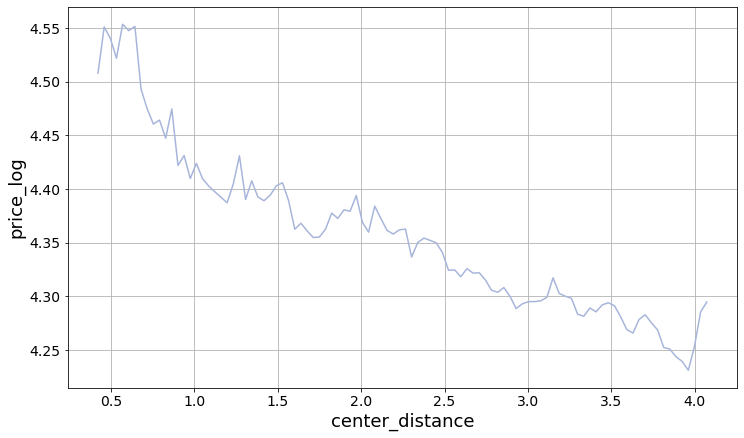

In [77]:
#partial dependence plot for 'center_distance'

partial_dependence_center_distance = partial_dependence(xgb_reg, X_train, ['center_distance'])
pd_center_distance_average = partial_dependence_center_distance['average'].tolist()[0]
pd_center_distance_values = partial_dependence_center_distance['values'][0].tolist()

plt.rcParams["figure.figsize"] = (12,7)

plt.plot(pd_center_distance_values, pd_center_distance_average, color='#A7B5DB')
plt.ylabel('price_log', fontsize=18)
plt.xlabel('center_distance', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

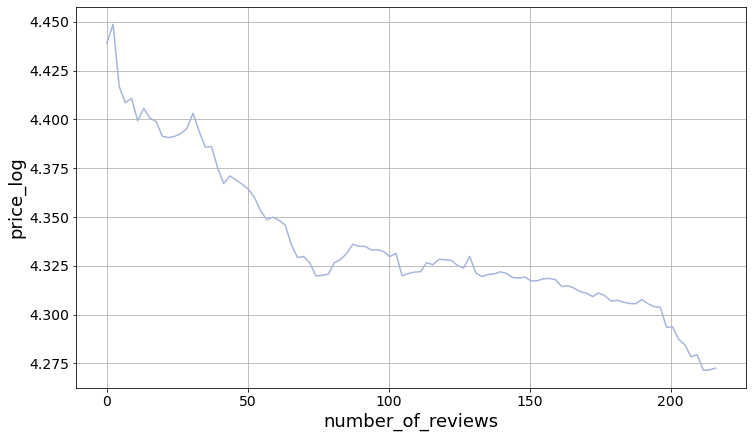

In [78]:
#partial dependence plot for 'number_of_reviews'

partial_dependence_number_of_reviews = partial_dependence(xgb_reg, X_train, ['number_of_reviews'])
pd_number_of_reviews_average = partial_dependence_number_of_reviews['average'].tolist()[0]
pd_number_of_reviews_values = partial_dependence_number_of_reviews['values'][0].tolist()

plt.rcParams["figure.figsize"] = (12,7)

plt.plot(pd_number_of_reviews_values, pd_number_of_reviews_average, color='#A7B5DB')
plt.ylabel('price_log', fontsize=18)
plt.xlabel('number_of_reviews', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# Conclusions <a class="anchor" id="Conclusions"></a>

With Validation MAPE value of 0.2244, model could be used as a tool assisting hosts in setting appropriate price for their accommodation facilites listed on Aibrnb platform as well as by tourists to determine whether property is worth its price. This model was built to predict rental prices in one city - Barcelona. However, due to the similar data structure that can also be obtained for other cities where Airbnb operates, it can be the basis for creating models for other cities as well, or even generalizing the model for cities occurring within a single country or geographic region.